In [1]:
from SimPEG import Mesh, Utils, Maps, Survey
from SimPEG.EM.Static import DC, IP
from pymatsolver import MumpsSolver
import sys
sys.path.append("../utilcodes/")
from vizutils import viz, gettopoCC, vizEJ
%pylab inline

/Users/sgkang/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
csx, csy, csz = 25., 25., 25.
ncx, ncy, ncz = 48, 48, 20
npad = 7
hx = [(csx,npad, -1.3),(csx,ncx),(csx,npad, 1.3)]
hy = [(csy,npad, -1.3),(csy,ncy),(csy,npad, 1.3)]
hz = [(csz,npad, -1.3),(csz,ncz), (csz/2.,6)]
mesh = Mesh.TensorMesh([hx, hy, hz],x0="CCN")

In [3]:
import matplotlib
matplotlib.rcParams['font.size'] = 14

In [4]:
sigma = mesh.readModelUBC("VTKout_DC.dat")

In [5]:
airind = sigma==1e-8
mesh2D, topoCC = gettopoCC(mesh, airind)

In [6]:
Aloc1_x = np.r_[-600., 0, 0.]
Bloc1_x = np.r_[600., 0, 0.]
Aloc2_x = np.r_[-350., 0, 0.]
Bloc2_x = np.r_[350., 0, 0.]

Aloc1_y = np.r_[0, -600., 0.]
Bloc1_y = np.r_[0, 600. , 0.]
Aloc2_y = np.r_[0, -350., 0.]
Bloc2_y = np.r_[0, 350. , 0.]

In [7]:
x = mesh.vectorCCx[np.logical_and(mesh.vectorCCx>-300., mesh.vectorCCx<300.)]
y = mesh.vectorCCy[np.logical_and(mesh.vectorCCy>-300., mesh.vectorCCy<300.)]

In [8]:
Mx = Utils.ndgrid(x[:-1], y, np.r_[-12.5/2.])
Nx = Utils.ndgrid(x[1:], y, np.r_[-12.5/2.])
My = Utils.ndgrid(x, y[:-1], np.r_[-12.5/2.])
Ny = Utils.ndgrid(x, y[1:], np.r_[-12.5/2.])

In [9]:
inds_Mx = Utils.closestPoints(mesh2D, Mx[:,:2])
inds_Nx = Utils.closestPoints(mesh2D, Nx[:,:2])
inds_My = Utils.closestPoints(mesh2D, My[:,:2])
inds_Ny = Utils.closestPoints(mesh2D, Ny[:,:2])

In [10]:
Mx_dr = np.c_[Mx[:,0], Mx[:,1], topoCC[inds_Mx]]
Nx_dr = np.c_[Nx[:,0], Nx[:,1], topoCC[inds_Nx]]
My_dr = np.c_[My[:,0], My[:,1], topoCC[inds_My]]
Ny_dr = np.c_[Ny[:,0], Ny[:,1], topoCC[inds_Ny]]

(-800, 800)

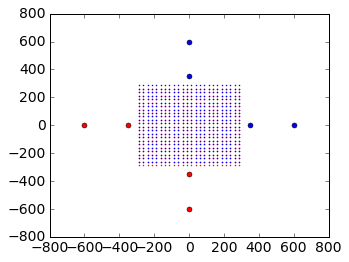

In [11]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
ax.plot(Aloc1_x[0], Aloc1_x[1], 'ro', ms=5)
ax.plot(Bloc1_x[0], Bloc1_x[1], 'bo', ms=5)
ax.plot(Aloc2_x[0], Aloc2_x[1], 'ro', ms=5)
ax.plot(Bloc2_x[0], Bloc2_x[1], 'bo', ms=5)
ax.plot(Aloc1_y[0], Aloc1_y[1], 'ro', ms=5)
ax.plot(Bloc1_y[0], Bloc1_y[1], 'bo', ms=5)
ax.plot(Aloc2_y[0], Aloc2_y[1], 'ro', ms=5)
ax.plot(Bloc2_y[0], Bloc2_y[1], 'bo', ms=5)


ax.plot(My[:,0], My[:,1], 'r.', ms=2)
ax.plot(Ny[:,0], Ny[:,1], 'b.', ms=2)
# dat = mesh2D.plotImage(topoCC, ax=ax, pcolorOpts={'alpha':0.2})
# plt.colorbar(dat[0])
ax.set_xlim(-800, 800)
ax.set_ylim(-800, 800)


In [12]:
rx_x = DC.Rx.Dipole(Mx_dr, Nx_dr)
rx_y = DC.Rx.Dipole(My_dr, Ny_dr)
# src0 = DC.Src.Dipole([rx_x, rx_y], Aloc0_x, Bloc0_x)
src1 = DC.Src.Dipole([rx_x, rx_y], Aloc1_x, Bloc1_x)
src2 = DC.Src.Dipole([rx_x, rx_y], Aloc2_x, Bloc2_x)
src3 = DC.Src.Dipole([rx_x, rx_y], Aloc1_y, Bloc1_y)
src4 = DC.Src.Dipole([rx_x, rx_y], Aloc2_y, Bloc2_y)

In [13]:
survey = DC.Survey([src1, src2, src3, src4])
problem = DC.Problem3D_CC(mesh)
problem.Solver = MumpsSolver
problem.pair(survey)
f = problem.fields(sigma)
dobs = survey.dpred(sigma, f=f)

In [14]:
dcdata = Survey.Data(survey, v=dobs)
Xx = 0.5*(Mx[:,0]+Nx[:,0]).reshape((23, 24), order="F")
Yx = Mx[:,1].reshape((23, 24), order="F")
Xy = My[:,0].reshape((24, 23), order="F")
Yy = 0.5*(My[:,1]+Ny[:,1]).reshape((24, 23), order="F")

In [15]:
sigopt = np.load("sigest.npy")

In [16]:
eta = mesh.readModelUBC("VTKout_eta.dat")
actmapIP = Maps.InjectActiveCells(mesh, ~airind, 0.)
problemIP = IP.Problem3D_CC(mesh, rho=1./sigma, Ainv=problem.Ainv, f=f, mapping=actmapIP)
problemIP.Solver = MumpsSolver
surveyIP = IP.Survey([src1, src2, src3, src4])
problemIP.pair(surveyIP)
dataIP = surveyIP.dpred(eta[~airind])

In [17]:
import pickle
Results = pickle.load(open("IPresults", 'rb')) 

In [18]:
np.unique(eta)*1e3

array([ 0.   ,  0.375,  1.567])

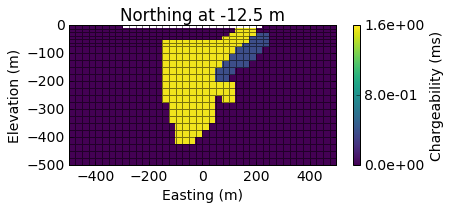

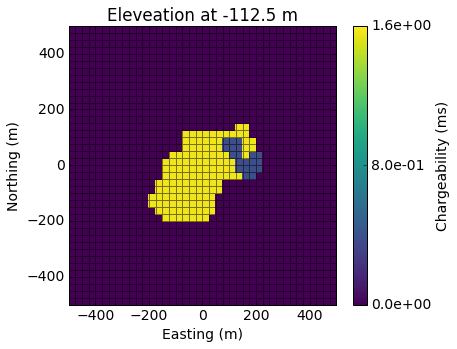

In [19]:
viz(mesh, eta*1e3, 30, airind=airind, normal="Y", scale="linear", clim=(0, 1.6), label="Chargeability (ms)")
viz(mesh, eta*1e3, 26, airind=airind, normal="Z", scale="linear", clim=(0, 1.6), label="Chargeability (ms)")

In [20]:
survey = DC.Survey([src1, src2, src3, src4])
problem = DC.Problem3D_CC(mesh)
problem.Solver = MumpsSolver
problem.pair(survey)
f = problem.fields(sigopt)
problemIP = IP.Problem3D_CC(mesh, rho=1./sigopt, Ainv=problem.Ainv, f=f, mapping=actmapIP)
problemIP.Solver = MumpsSolver
surveyIP = IP.Survey([src1, src2, src3, src4])
problemIP.pair(surveyIP)

In [21]:
import pickle
Results = pickle.load(open("IPresults", "rb"))

In [22]:
# interact(lambda ind: viz(eta, ind, normal="Z"), ind=IntSlider(min=0, max=32,step=1, value=30))

In [23]:
ipdata = Survey.Data(surveyIP, v=dataIP)

In [24]:
def vizdata(data, src, rx, rxcomponent="X", clim=None, title=None, figsave=None, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(6.8, 5.5))
        ax = plt.subplot(111)

    temp = data[src, rx]
    if rxcomponent=="X":
        X = Xx.copy()
        Y = Yx.copy()
    else:
        X = Xy.copy()
        Y = Yy.copy()
    temp = temp.reshape(X.shape, order="F")
    if clim is not None:
        vmin, vmax = clim[0], clim[1]
        dat = ax.contourf(X, Y, temp, 20, clim=clim, vmin=vmin, vmax=vmax, cmap="viridis")
        ax.contour(X, Y, temp, 10, colors="k")
    else:
        vmin, vmax = temp.min(), temp.max()
        dat = ax.contourf(X, Y, temp, 20, cmap="viridis")
        ax.contour(X, Y, temp, 10, colors="k")
        
    if title is not None:
        ax.set_title(title)
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.axis("equal")

    cb = plt.colorbar(dat, ticks=np.linspace(vmin, vmax, 3), format="%.1e")
    cb.set_label("Potential (V)")
    if figsave is not None:
        fig.savefig(figsave, dpi=200)
    

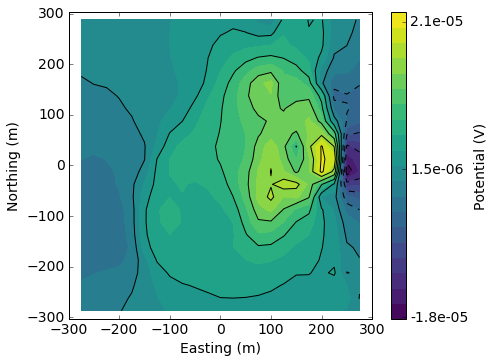

In [25]:
vizdata(ipdata, src1, rx_x)

(-300, 300)

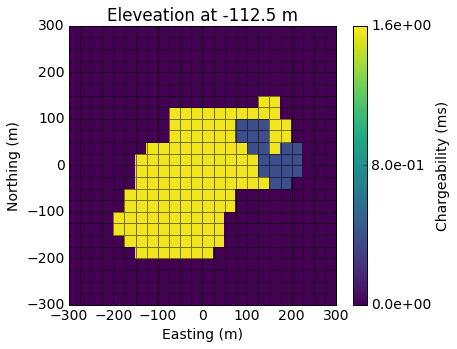

In [26]:
ax = viz(mesh, eta*1e3, 26, airind=airind, normal="Z", scale="linear", clim=(0, 1.6), label="Chargeability (ms)")
ax.set_xlim(-300, 300)
ax.set_ylim(-300, 300)

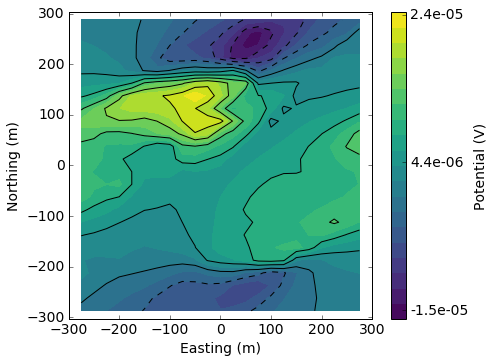

In [27]:
vizdata(ipdata, src3, rx_y)

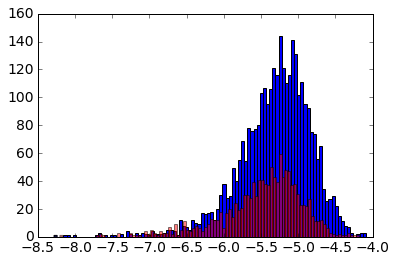

In [28]:
a = hist(np.log10(dataIP[dataIP>0.]), bins=100)
b = hist(np.log10(-dataIP[dataIP<0.]), bins=100, color='r', alpha=0.5)

In [29]:
depth = 1./(abs(mesh.gridCC[:,2]))**1.5
depth = depth/depth.max()

In [32]:
from SimPEG import DataMisfit, Regularization, Optimization, Directives, InvProblem, Inversion
std = 0.
eps = 10**(-5.5)
surveyIP.std = std
surveyIP.eps = eps
m0 = np.ones(mesh.nC)[~airind]*1e-20
regmap = Maps.IdentityMap(nP=m0.size)
#TODO put warning when dobs is not set!
surveyIP.dobs = dataIP
dmisfit = DataMisfit.l2_DataMisfit(surveyIP)
reg = Regularization.Simple(mesh, mapping=regmap, indActive=~airind)
reg.wght = depth[~airind]
opt = Optimization.ProjectedGNCG(maxIter = 10)
opt.lower = 0.
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
# Create an inversion object
beta = Directives.BetaSchedule(coolingFactor=5, coolingRate=3)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1.)
save = Directives.SaveOutputEveryIteration()
target = Directives.TargetMisfit()
# beta.beta = 10.
inv = Inversion.BaseInversion(invProb, directiveList=[betaest, beta, save, target, savemodel])
reg.alpha_s = 1e-1
reg.alpha_x = 1.
reg.alpha_y = 1.
reg.alpha_z = 1.
problemIP.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
mIPopt = inv.run(m0)
# problemIP.Ainv.clean()

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveOutputEveryIteration will save your inversion progress as: '###-InversionModel-2016-07-03-13-35.txt'
SimPEG.SaveModelEveryIteration will save your models as: '###-InversionModel-2016-07-03-13-35.npy'
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  2.09e+05  2.52e+04  0.00e+00  2.52e+04    1.36e+07      0              
   1  2.09e+05  1.43e+04  1.91e-03  1.47e+04    1.57e+07      0              
   2  2.09e+05  6.15e+03  1.19e-02  8.62e+03    6.30e+06      0   Skip BFGS  
   3  4.18e+04  3.82e+03  1.59e-02  4.49e+03    7.12e+06      0              
------------------------- STOP! -------

In [33]:
dmisfit.eval(mIPopt)

1255.5089382546487

In [35]:
surveyIP.nD

2208

In [31]:
# savemodel = Directives.SaveModelEveryIteration()

In [36]:
# import pickle
# eta_pred = actmapIP*mIPopt
# Results = {"model_true":eta, "model_pred":eta_pred, "Obs":surveyIP.dobs, "Pred":invProb.dpred}
# outputs = open("IPresults", 'wb')
# pickle.dump(Results, outputs)
# outputs.close()

In [37]:
# print mesh.nC, mIPopt.shape
eta_pred = Results["model_pred"]
dpred = Results["Pred"]
dobs = Results["Obs"]

In [38]:
mIPopt = eta_pred[~airind]
phid = dmisfit.eval(mIPopt)

In [39]:
print phid

1141.81083438


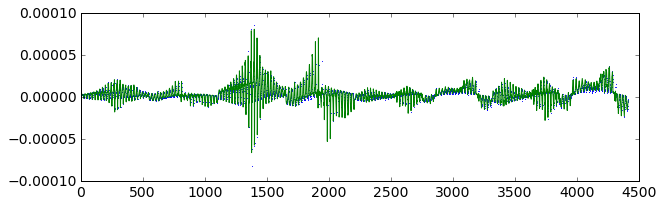

In [40]:
figsize(10, 3)
plt.plot(dpred, '.', ms=1)
plt.plot(dobs)

In [41]:
ippred = Survey.Data(surveyIP, v=dpred)

In [42]:
from ipywidgets import interact, IntSlider

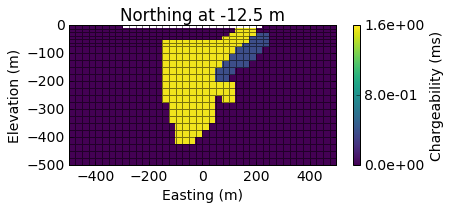

In [46]:
interact(lambda ind: viz(mesh, eta*1e3, ind, airind=airind, normal="Y", scale="linear", clim=(0, 1.6), label="Chargeability (ms)")
, ind=IntSlider(min=0, max=40,step=1, value=28))

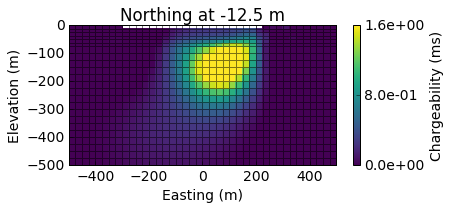

In [44]:
interact(lambda ind: viz(mesh, eta_pred*1e3, ind, airind=airind, normal="Y", scale="linear", clim=(0, 1.6), label="Chargeability (ms)")
, ind=IntSlider(min=0, max=40,step=1, value=30))

<function __main__.<lambda>>

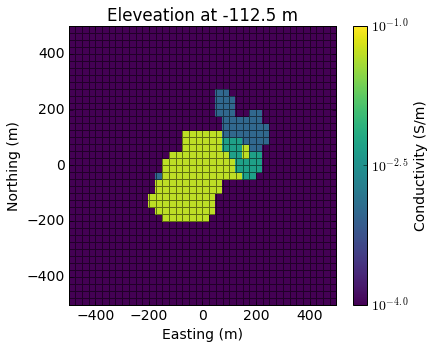

In [49]:
interact(lambda ind: viz(mesh, sigma, ind, airind=airind, normal="Z"), ind=IntSlider(min=0, max=40,step=1, value=26))

<function __main__.<lambda>>

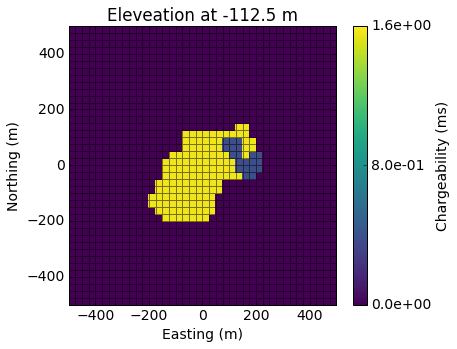

In [47]:
interact(lambda ind: viz(mesh, eta*1e3, ind, airind=airind, normal="Z", scale="linear", clim=(0, 1.6), label="Chargeability (ms)"), ind=IntSlider(min=0, max=40,step=1, value=26))

<function __main__.<lambda>>

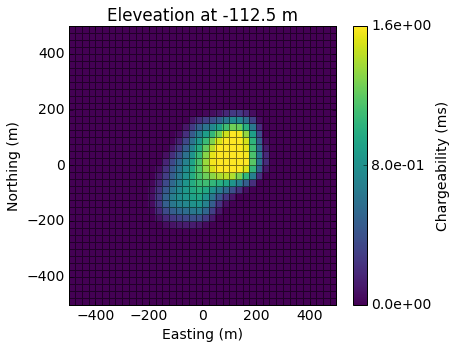

In [48]:
interact(lambda ind: viz(mesh, eta_pred*1e3, ind, airind=airind, normal="Z", scale="linear", clim=(0, 1.6), label="Chargeability (ms)"), ind=IntSlider(min=0, max=40,step=1, value=26))